# Customer segmentation on <i>Online Retail Data Set</i>
by Nelson Cárdenas

Customer segmentation (or market segmentation) are techniques to split customers into clusters based on similarities to get a sense of their behavior. In this notebook, we are going to analyze patterns in the Online Retail Data Set from the UCI Machine Learning Repository. As UCI specifies about their dataset:

* <i>"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."</i>

Columns description

* <b>InvoiceNo:</b> A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).
* <b>StockCode:</b> Identifier for items contained in an invoice.
* <b>Description:</b> Textual description of each of the stock items.
* <b>Quantity:</b> The quantity of the item purchased.
* <b>InvoiceDate:</b> Date of purchase.
* <b>UnitPrice:</b> Value of each item.
* <b>CustomerID:</b> Identifier for customer making the purchase.
* <b>Country:</b> Country of customer.

This notebook is based on work made by some authors, see section "References"

In [34]:
import pandas as pd
import plotly.express as px
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import math
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

We load the dataset and describe the type of data

In [35]:
pd.__version__

'2.2.3'

In [36]:
df_ori = pd.read_excel(io='Online Retail.xlsx')

In [37]:
df_copy = df_ori.copy()
df_ori[:3]

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom

In [38]:
import numpy as np
import pandas as pd

def describe(df, pred=None):
    """This function describes a dataframe's basic information."""
    obs = df.shape[0]  # number of observations
    types = df.dtypes  # data types of columns
    counts = df.count()  # count of non-null values in each column
    uniques = df.nunique()  # number of unique values in each column
    nulls = df.isnull().sum()  # number of null values in each column
    distincts = df.nunique()  # distinct count of values
    missing_ratio = (df.isnull().sum() / obs) * 100  # percentage of missing values
    skewness = df.skew(numeric_only=True)  # skewness (only for numeric columns)
    kurtosis = df.kurt(numeric_only=True)  # kurtosis (only for numeric columns)
    
    # Handle unique values for categorical columns (limit to top 10 unique values for readability)
    uniques_values = df.apply(lambda x: ', '.join(map(str, x.unique()[:10])) if x.dtype == 'object' else None)

    print('Data shape:', df.shape)

    if pred is None:
        # If no prediction column is specified, include basic stats
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ratio', 'uniques', 'skewness', 'kurtosis']
        output = pd.DataFrame({
            'types': types,
            'counts': counts,
            'distincts': distincts,
            'nulls': nulls,
            'missing ratio': missing_ratio,
            'uniques': uniques_values,
            'skewness': skewness,
            'kurtosis': kurtosis
        })
    else:
        # If prediction column is specified, include correlation with pred
        corr = df.corr()[pred]  # correlation with the given column
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ratio', 'uniques', 'skewness', 'kurtosis', f'corr {pred}']
        output = pd.DataFrame({
            'types': types,
            'counts': counts,
            'distincts': distincts,
            'nulls': nulls,
            'missing ratio': missing_ratio,
            'uniques': uniques_values,
            'skewness': skewness,
            'kurtosis': kurtosis,
            f'corr {pred}': corr
        })
    
    # Display the data types count
    print('___________________________\nData types:\n', output['types'].value_counts())
    print('___________________________')

    # Return the result sorted by missing ratio
    return output.sort_values(by='missing ratio', ascending=False)

details = describe(df_ori)
display(details.sort_values(by='missing ratio', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
 types
object            4
float64           2
datetime64[ns]    1
int64             1
Name: count, dtype: int64
___________________________


types  counts  distincts   nulls  missing ratio  \
CustomerID          float64  406829       4372  135080      24.926694   
Description          object  540455       4223    1454       0.268311   
Country              object  541909         38       0       0.000000   
InvoiceDate  datetime64[ns]  541909      23260       0       0.000000   
InvoiceNo            object  541909      25900       0       0.000000   
Quantity              int64  541909        722       0       0.000000   
StockCode            object  541909       4070       0       0.000000   
UnitPrice           float64  541909       1630       0       0.000000   

                                                       uniques    skewness  \
CustomerID                                                None    0.029835   
Description  WHITE HANGING HEART T-LIGHT HOLDER, WHITE META...         NaN   
Country      United Kingdom, France, Australia, Netherlands...         NaN   
InvoiceDate                                               None         NaN   
InvoiceNo    536365, 536366, 536367, 536368, 536369, 536370...         NaN   
Quantity                                                  None   -0.264076   
StockCode    85123A, 71053, 84406B, 84029G, 84029E, 22752, ...         NaN   
UnitPrice                                                 None  186.506972   

                  kurtosis  
CustomerID       -1.179982  
Description            NaN  
Country                NaN  
InvoiceDate            NaN  
InvoiceNo              NaN  
Quantity     119769.160031  
StockCode              NaN  
UnitPrice     59005.719097

In [39]:
df_ori.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

For Quantity and Unit price we have negative values, this can be caused by product returns. We must avoid these values, but first we are going to look at the data

In [40]:
df_ori = df_copy.copy()
bool_error = (df_ori['Quantity']<=0) | (df_ori['UnitPrice']<=0)
print('With Quantity negative and UnitPrice negative:', df_ori[(df_ori['Quantity']<0) & (df_ori['UnitPrice']<0)].shape[0])
print('With Quantity or UnitPrice negative or equals to zero:', df_ori[bool_error].shape[0])
print('Values errors by percentage:', str(df_ori[bool_error].shape[0]/df_ori.shape[0]*100)[:5], '%')
print('CustomerIDs with these anomalous values are:', df_ori[bool_error]['CustomerID'].unique())

With Quantity negative and UnitPrice negative: 0
With Quantity or UnitPrice negative or equals to zero: 11805
Values errors by percentage: 2.178 %
CustomerIDs with these anomalous values are: [14527. 15311. 17548. ... 12985. 15951. 16446.]


Values without customer information or with zero or negative quantity opr price will be removed

In [41]:
df_ori = df_ori[~(bool_error | df_ori['CustomerID'].isnull())]

In [42]:
details = describe(df_ori)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 8)
___________________________
Data types:
 types
object            4
float64           2
datetime64[ns]    1
int64             1
Name: count, dtype: int64
___________________________


types  counts  distincts  nulls  missing ratio  \
InvoiceNo            object  397884      18532      0            0.0   
InvoiceDate  datetime64[ns]  397884      17282      0            0.0   
CustomerID          float64  397884       4338      0            0.0   
Description          object  397884       3877      0            0.0   
StockCode            object  397884       3665      0            0.0   
UnitPrice           float64  397884        440      0            0.0   
Quantity              int64  397884        301      0            0.0   
Country              object  397884         37      0            0.0   

                                                       uniques    skewness  \
InvoiceNo    536365, 536366, 536367, 536368, 536369, 536370...         NaN   
InvoiceDate                                               None         NaN   
CustomerID                                                None    0.025729   
Description  WHITE HANGING HEART T-LIGHT HOLDER, WHITE META...         NaN   
StockCode    85123A, 71053, 84406B, 84029G, 84029E, 22752, ...         NaN   
UnitPrice                                                 None  204.032727   
Quantity                                                  None  409.892972   
Country      United Kingdom, France, Australia, Netherlands...         NaN   

                  kurtosis  
InvoiceNo              NaN  
InvoiceDate            NaN  
CustomerID       -1.180822  
Description            NaN  
StockCode              NaN  
UnitPrice     58140.396673  
Quantity     178186.243253  
Country                NaN

In [43]:
df_ori.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 14:39:00       1.950000   
75%        12.000000            2011-10-20 14:33:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       179.331775                            NaN      22.097877   

          CustomerID  
count  397884.000000  
mean    15294.423453  
min     12346.000000  
25%     13969.000000  
50%     15159.000000  
75%     16795.000000  
max     18287.000000  
std      1713.141560

In [44]:
stock_desc = df_ori.groupby(['StockCode','Description']).count().reset_index()
stock_desc_count = stock_desc['StockCode'].value_counts().reset_index()
stock_desc_count['StockCode'] = pd.to_numeric(stock_desc_count['StockCode'], errors='coerce')
stock_desc_count[stock_desc_count['StockCode']>1][:2]

StockCode  count
0    23196.0      4
1    23236.0      4

In [45]:
df_ori[df_ori['StockCode'] == 23196]['Description'].unique()

array(['RETRO LEAVES MAGNETIC NOTEPAD',
       'RETO LEAVES MAGNETIC SHOPPING LIST',
       'LEAVES MAGNETIC  SHOPPING LIST', 'VINTAGE LEAF MAGNETIC NOTEPAD'],
      dtype=object)

In [46]:
temp = df_ori['Description'].groupby(df_ori['StockCode']).unique().apply(pd.Series)
temp = temp[0].to_dict()
df_ori['Description'] = df_ori['StockCode'].map(temp)

df_ori['CustomerID'] = df_ori['CustomerID'].astype('int32')

In [47]:
df_ori[df_ori['StockCode'] == 23196]['Description'].unique()

array(['RETRO LEAVES MAGNETIC NOTEPAD'], dtype=object)

We validate the result with the describe function

In [48]:
details = describe(df_ori)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 8)
___________________________
Data types:
 types
object            4
int32             1
datetime64[ns]    1
int64             1
float64           1
Name: count, dtype: int64
___________________________


types  counts  distincts  nulls  missing ratio  \
InvoiceNo            object  397884      18532      0            0.0   
InvoiceDate  datetime64[ns]  397884      17282      0            0.0   
CustomerID            int32  397884       4338      0            0.0   
StockCode            object  397884       3665      0            0.0   
Description          object  397884       3647      0            0.0   
UnitPrice           float64  397884        440      0            0.0   
Quantity              int64  397884        301      0            0.0   
Country              object  397884         37      0            0.0   

                                                       uniques    skewness  \
InvoiceNo    536365, 536366, 536367, 536368, 536369, 536370...         NaN   
InvoiceDate                                               None         NaN   
CustomerID                                                None    0.025729   
StockCode    85123A, 71053, 84406B, 84029G, 84029E, 22752, ...         NaN   
Description  WHITE HANGING HEART T-LIGHT HOLDER, WHITE META...         NaN   
UnitPrice                                                 None  204.032727   
Quantity                                                  None  409.892972   
Country      United Kingdom, France, Australia, Netherlands...         NaN   

                  kurtosis  
InvoiceNo              NaN  
InvoiceDate            NaN  
CustomerID       -1.180822  
StockCode              NaN  
Description            NaN  
UnitPrice     58140.396673  
Quantity     178186.243253  
Country                NaN

### Analyze sales
We analyzed plotting of sales with respect to some of the other variables.

* Market representation and country

In [49]:
df_ori['Internal'] = 'No'
df_ori.loc[df_ori['Country'] == 'United Kingdom', 'Internal'] = 'Yes'
fig = px.pie(df_ori, names='Internal', title='Market representation', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

df_ori['Amount'] = df_ori['UnitPrice']*df_ori['Quantity']
temp = pd.DataFrame(df_ori.groupby('Country')['Amount'].sum()).reset_index().sort_values(by=['Amount'], ascending=False)
fig = px.bar(temp, x='Country', y='Amount', title='Amount sales by country',  color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

* Top Customers

In [50]:
temp = df_ori.groupby('CustomerID')[['Amount']].sum().sort_values(by=['Amount'], ascending=False)
ratio_sales_inplot = str(list(temp[:50].sum())[0] / list(temp.sum())[0] * 100)[:5] + ' %'
fig = px.bar(temp[:50].reset_index(), x='CustomerID', y='Amount', title='50 Best Customers by amount ('+ ratio_sales_inplot + ' of total amount of sales)', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis_type = 'category')
fig.show()

ratio_sales_inplot = str(list(temp[:10].sum())[0] / list(temp.sum())[0] * 100)[:5] + ' %'
fig = px.bar(temp[:10].reset_index(), x='CustomerID', y='Amount', title='10 Best Customers by amount ('+ ratio_sales_inplot + ' of total amount of sales)', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis_type = 'category')
fig.show()

temp = df_ori.groupby('CustomerID')[['Amount']].count().sort_values(by=['Amount'], ascending=False)
temp
ratio_sales_inplot = str(list(temp[:10].sum())[0] / list(temp.sum())[0] * 100)[:4] + ' %'
fig = px.bar(temp[:10].reset_index(), x='CustomerID', y='Amount', title='10 Best Customers by frecuency of sales ('+ ratio_sales_inplot + ' of total frequency of sales)', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis_type = 'category')
fig.show()


* Top products

In [51]:
temp = df_ori.groupby(['StockCode', 'Description'])['Amount'].sum().sort_values(ascending=False).reset_index()
ratio_sales_inplot = str(list(temp[['Amount']][:10].sum())[0] / list(temp[['Amount']].sum())[0] * 100)[:5] + ' %'
fig = px.bar(temp[:10].reset_index(), x='Description', y='Amount', title='10 best products by amount ('+ ratio_sales_inplot + ' of total amount of sales)', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis_type = 'category')
fig.update_traces(marker_color='rgb(246,207,113)')
fig.show()

temp = df_ori.groupby(['StockCode', 'Description'])[['Amount']].count().sort_values(by=['Amount'], ascending=False).reset_index()
ratio_sales_inplot = str(list(temp[['Amount']][:10].sum())[0] / list(temp[['Amount']].sum())[0] * 100)[:5] + ' %'
fig = px.bar(temp[:10].reset_index(), x='Description', y='Amount', title='10 best products by frequency ('+ ratio_sales_inplot + ' of total frequency of sales)', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis_type = 'category')
fig.update_traces(marker_color='rgb(246,207,113)')
fig.show()

### Customer Segementation with RFM

We are going to use the Recency, Frequency, Monetary Model (RFM). As stated in the Wikipedia page, RFM stands for the three dimensions:
   * <b>Recency</b> – How recently did the customer purchase?
   * <b>Frequency</b> – How often do they purchase?
   * <b>Monetary Value</b> – How much do they spend?
   
This analysis must be careful with the time window because can be biased or inaccurate if we try to span an extremely long duration.

In [52]:
snapshot_date = df_ori['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [53]:
#Extract features for each customer
data_process = df_ori.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'Amount': 'sum'})

#renaming
data_process.columns = ['Recency', 'Frequency', 'MonetaryValue']

data_process = data_process
data_process[:3]

Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2        182        4310.00
12348            75         31        1797.24

Let's going to look at the distribution of our data

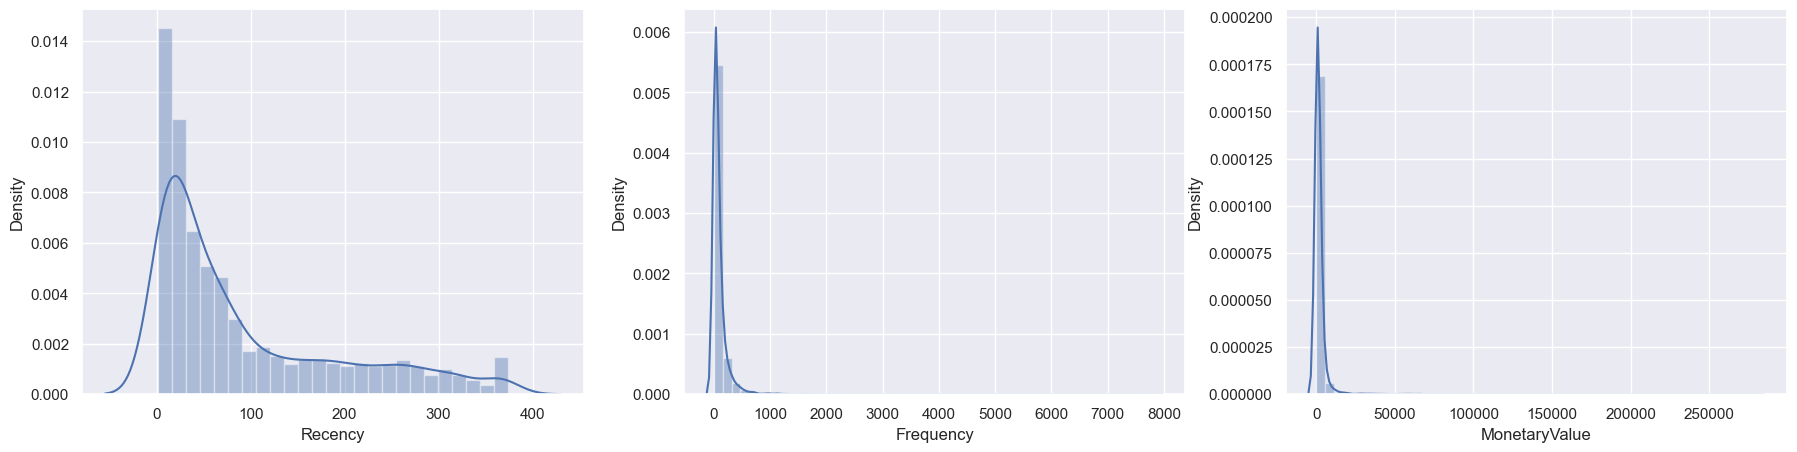

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
for i, feature in enumerate(list(data_process.columns)):
    sns.distplot(data_process[feature], ax=axes[i])

The data is skewed. Using log transformation we can improve the quality of the data for future analysis

In [55]:
data_process['Recency_log'] = data_process['Recency'].apply(math.log)
data_process['Frequency_log'] = data_process['Frequency'].apply(math.log)
data_process['MonetaryValue_log'] = data_process['MonetaryValue'].apply(math.log)
data_process[:3]

Recency  Frequency  MonetaryValue  Recency_log  Frequency_log  \
CustomerID                                                                  
12346           326          1       77183.60     5.786897       0.000000   
12347             2        182        4310.00     0.693147       5.204007   
12348            75         31        1797.24     4.317488       3.433987   

            MonetaryValue_log  
CustomerID                     
12346               11.253942  
12347                8.368693  
12348                7.494007

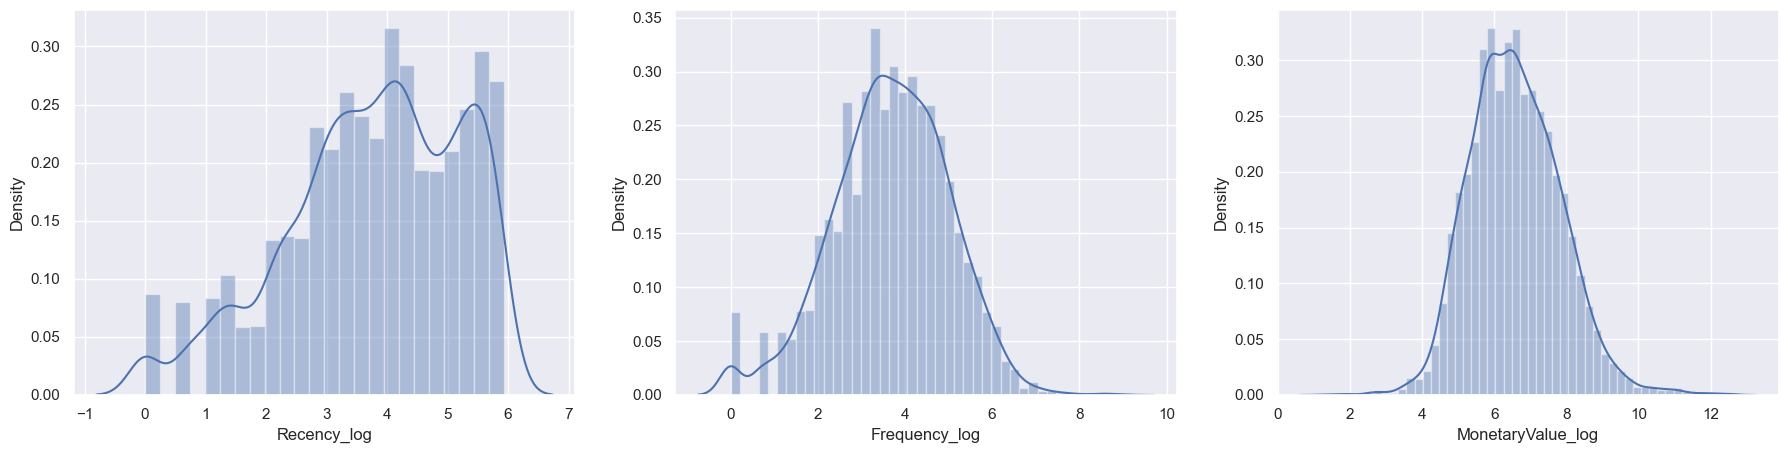

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
        
for i, feature in enumerate(list(data_process.columns[3:])):
    sns.distplot(data_process[feature], ax=axes[i])

Now let's normalized our data, this improves the k-means performance. We choose to use MinMaxScaler and changed the column names, then we use describe to analyze the results.

In [57]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
data_process_normalized = pd.DataFrame(scaler.fit_transform(data_process))
#renaming
data_process_normalized.columns = ['n_'+ i for i in data_process.columns]
data_process_normalized.describe()
data_process.to_csv('data_process.csv')
data_process_normalized.to_csv('data_process_normalized_description.csv')

Now we are going to plot the inertia for each cluster from 1 to 15

In [58]:
SSE, max_k = [], 15
list_input = list(data_process_normalized.columns[3:])
for k in range(max_k):
    kmeans = KMeans(n_clusters=k+1, random_state=42).fit(data_process_normalized[list_input])
    SSE.append(kmeans.inertia_)

# fig, ax = plt.subplots()
# ax.plot(range(1, max_k + 1), SSE, marker='o')
# ax.set_xlabel('Number of Clusters')
# ax.set_ylabel('Sum of Squared Errors (SSE)')
# plt.show()
fig = go.Figure(data=go.Scatter(x=list(range(1, max_k+1)), y=SSE, ))
fig.update_traces(marker_size=14)
fig.show()

Using the elbow heuristic We decide to use k = 5 for our model.

In [59]:
# model = KMeans(n_clusters=5, random_state=42)
# data_process_normalized['cluster'] = model.predict(data_process_normalized)
model =  KMeans(n_clusters=5, random_state=42).fit(data_process_normalized[list_input])
data_process_normalized['cluster'] = model.predict(data_process_normalized[list_input])
fig = px.scatter_3d(data_process_normalized, x=list_input[0], y=list_input[1], z=list_input[2],
              color='cluster')
fig.show()

In [60]:
features = ['n_Recency', 'n_Frequency', 'n_MonetaryValue']
target = 'cluster'
X = data_process_normalized[features]
y = data_process_normalized[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.9735
Confusion Matrix:
[[156   1   0   0   0]
 [  3 198   0   0   3]
 [  1   0 213   0   6]
 [  0   0   0  92   0]
 [  5   2   2   0 186]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       157
           1       0.99      0.97      0.98       204
           2       0.99      0.97      0.98       220
           3       1.00      1.00      1.00        92
           4       0.95      0.95      0.95       195

    accuracy                           0.97       868
   macro avg       0.98      0.98      0.98       868
weighted avg       0.97      0.97      0.97       868



Train-test split for training the Random Forest model on Online Retail

In [62]:
# Step 8: Load the recreated sample dataset (CSV file)
sample_file_path = 'recreated_sample_online_retail.csv'  # Ensure the correct file path for the recreated CSV
df_sample = pd.read_csv(sample_file_path)

# Step 9: Ensure that the recreated sample data has the expected columns
normalized_features = ['n_Recency', 'n_Frequency', 'n_MonetaryValue']
df_sample_normalized = df_sample[normalized_features]  # Use only the columns that are normalized

# Check if the columns are correctly loaded
print("Columns in the sample dataset:", df_sample_normalized.columns)

# Step 10: Make predictions on the sample dataset using the trained Random Forest model
y_sample_pred = rf_model.predict(df_sample_normalized)

# Step 11: Display the predicted clusters for the sample dataset
df_sample['predicted_cluster'] = y_sample_pred

# Print the result (predicted clusters for the sample dataset)
print("Predicted clusters for the sample data:")
print(df_sample[['n_Recency', 'n_Frequency', 'n_MonetaryValue', 'predicted_cluster']])

Columns in the sample dataset: Index(['n_Recency', 'n_Frequency', 'n_MonetaryValue'], dtype='object')
Predicted clusters for the sample data:
    n_Recency  n_Frequency  n_MonetaryValue  predicted_cluster
0    0.871314     0.000000         0.275443                  2
1    0.002681     0.023069         0.015368                  3
2    0.198391     0.003824         0.006401                  4
3    0.048257     0.009177         0.006259                  1
4    0.828418     0.002039         0.001180                  2
5    0.093834     0.010706         0.008930                  1
6    0.544236     0.000382         0.000304                  2
7    0.619303     0.007265         0.003839                  4
8    0.571046     0.001529         0.001626                  2
9    0.058981     0.007392         0.010020                  1
10   0.085791     0.016569         0.022141                  1


In [ ]:
data_process_normalized[:3]

n_Recency  n_Frequency  n_MonetaryValue  n_Recency_log  n_Frequency_log  \
0   0.871314     0.000000         0.275443       0.976814         0.000000   
1   0.002681     0.023069         0.015368       0.117002         0.580294   
2   0.198391     0.003824         0.006401       0.728782         0.382920   

   n_MonetaryValue_log  cluster  
0             0.885101        2  
1             0.627984        3  
2             0.550037        4

In [ ]:
data_process_normalized.groupby('cluster').agg({
    'n_Recency': ['mean', 'min', 'max'],
    'n_Frequency': ['mean', 'min', 'max'],
    'n_MonetaryValue': ['mean', 'min', 'max']
})

n_Recency                     n_Frequency                      \
             mean       min       max        mean       min       max   
cluster                                                                 
0        0.093091  0.005362  0.211796    0.002599  0.000000  0.012108   
1        0.054117  0.016086  0.176944    0.021187  0.003314  0.208514   
2        0.618281  0.168901  1.000000    0.001865  0.000000  0.010706   
3        0.006027  0.000000  0.018767    0.033806  0.000127  1.000000   
4        0.285520  0.096515  0.994638    0.009247  0.000765  0.069080   

        n_MonetaryValue                      
                   mean       min       max  
cluster                                      
0              0.001512  0.000011  0.024887  
1              0.011871  0.000766  0.445788  
2              0.001528  0.000000  0.275443  
3              0.026163  0.000415  1.000000  
4              0.004829  0.000469  0.158923

With this, we are done. We can define our clients based on the mean and range of values in each cluster. Further analysis includes using scorings based on RFM ranges. Also, we can use more robust analysis for the clustering, using not only RFM but other metrics such as demographics or product features.

### References

* Customer Segmentation and Market Basket Analysis by <i>Marcelo Marques</i>
https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis


* Recency, Frequency, Monetary Model with Python — and how Sephora uses it to optimize their Google and Facebook Ads by <i>Yexi Yuan</i>
https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17


* Exploring Customers Segmentation With RFM Analysis and K-Means Clustering With Python by <i>Hs.T</i>
https://medium.com/swlh/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-93aa4c79f7a7